# NLP spelling mistake feature engineering

When attempting to predict scores from a Kaggle competition essay text dataset, spelling mistakes could be a potentially useful feature. Yet creating an accurate spelling mistakes feature is not as easy as it seems. The spellchecker Python library can indicate if a word is recognized or not, but it doesn't account for punctuation stripped contractions, digits, decades nor a variety of other common word types. Applying some general remedies for these shortcomings improves our spelling mistake feature's correlation with the y variable (essay scores) by 2.67%.

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('data/train.csv')
train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## Initial spelling mistake functions

In [2]:
import re
import string
from spellchecker import SpellChecker
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# runs through the preprocessing steps
def standard_preprocess_text(text):

    # removes unprintable characters
    unprintable = r"[^\w\s]"
    text = re.sub(unprintable, '', text)

    # removes non-breaking space characters
    non_breaking = '\xa0'
    text = re.sub(non_breaking, ' ', text)

    # removes newline characters
    newline = '\n'
    text = re.sub(newline, ' ', text)
    
    # removes punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # lowercases the text
    text = text.lower()
    
    # tokenizes the text
    tokens = word_tokenize(text)
    
    # remove stopwords and digits
    tokens = [token for token in tokens if token not in stop_words]
    
    # joins the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text


# creates a spellchecker object
spell = SpellChecker()


# returns a count of misspelled words
def misspelling_count(essay):

    # loops through each word in an essay
    misspelled_count = 0
    misspelled_words = []
    words = essay.split()
    for word in words:
        
        # first checks if word is known
        if not spell.known([word]):

            # adds to the count of misspelled words
            misspelled_count += 1
            misspelled_words.append(word)

    ratio = misspelled_count / len(words)
            
    return misspelled_count, misspelled_words, ratio

## Problems

If we apply the common preprocessing steps above to the text, the removal of punctuation means that correctly spelled words involving contractions might be wrongly be labelled as misspelled. Additionally, the spellchecker library does not recognize digits, decades and several other types of correctly spelled words, potentially adding unhelpful noise to our spelling mistakes feature.

In [3]:
# prints out unrecognized words from specific essays
def outline_problems(i, title='Unknown Words', words=None):
    
    essay_example = standard_preprocess_text(train.loc[i, 'full_text'])
    results = misspelling_count(essay_example)
    
    pattern = '\d{4}s'
    
    print()

    if words == None:
        print(title + ': ' + str(set([x for x in results[1] if x.isdigit() or re.search(pattern, x)])))
    else:
        print(title + ': ' + str(set([x for x in results[1] if x in words])))
    
    print()


# prints problem examples from different essays
outline_problems(9, 'Contractions', ['youd', 'dont', 'didnt'])
outline_problems(21, 'Digits', ['2006'])
outline_problems(98, 'Decades', ['1800s', '1940s'])
outline_problems(0, 'Continents', ['europe'])
outline_problems(8, 'Planets', ['venus'])
outline_problems(102, 'Temperature measures', ['fahrenheit'])
outline_problems(967, 'Months', ['april'])
outline_problems(4067, 'Major wars', ['wwii'])
outline_problems(2067, 'Tech terms', ['driverless', 'nasa', 'gps', 'google', 'sergey', 'brin', 'prius'])


Contractions: {'dont', 'didnt', 'youd'}


Digits: {'2006'}


Decades: {'1800s', '1940s'}


Continents: {'europe'}


Planets: {'venus'}


Temperature measures: {'fahrenheit'}


Months: {'april'}


Major wars: {'wwii'}


Tech terms: {'driverless', 'google', 'gps', 'brin', 'sergey', 'prius'}



## Solutions

### Refined preprocessing

##### Key points:

- Correctly spelt contractions are eliminated (stripping punctuation during preprocessing otherwise complicates this).
- Digits and decades are removed because the spellchecker library does not recognize them as words.
- A number of other word types are also removed as the spellchecker library does not recognize them.

In [4]:
contractions = [
    "ain't", "aren't", "can't", "can't've", "could've",
    "couldn't", "couldn't've", "didn't", "doesn't", "don't", "hadn't",
    "hadn't've", "hasn't", "haven't", "he'd", "he'd've", "he'll",
    "he'll've", "he's", "how'd", "how'd'y", "how'll", "how's", "I'd",
    "I'd've", "I'll", "I'll've", "I'm", "I've", "isn't", "it'd",
    "it'd've", "it'll", "it'll've", "it's", "let's", "ma'am", "might've",
    "mightn't", "mightn't've", "must've", "mustn't", "mustn't've", "needn't",
    "needn't've", "o'clock", "oughtn't", "oughtn't've", "shan't", "sha'n't",
    "shan't've", "she'd", "she'd've", "she'll", "she'll've", "she's", "should've",
    "shouldn't", "shouldn't've", "that'd", "that'd've", "that's",
    "there'd", "there'd've", "there's", "they'd", "they'd've", "they'll", "they'll've",
    "they're", "they've", "to've", "wasn't", "we'd", "we'd've", "we'll", "we'll've",
    "we're", "we've", "weren't", "what'll", "what'll've", "what're", "what's", "what've",
    "when's", "when've", "where'd", "where's", "where've", "who'll", "who'll've", "who's",
    "who've", "why's", "why've", "will've", "won't", "won't've", "would've", "wouldn't",
    "wouldn't've", "you'd", "you'd've", "you'll", "you'll've", "you're", "you've", 
    "Ain't", "Aren't", "Can't", "Can't've", "Could've",
    "Couldn't", "Couldn't've", "Didn't", "Doesn't", "Don't", "Hadn't",
    "Hadn't've", "Hasn't", "Haven't", "He'd", "He'd've", "He'll",
    "He'll've", "He's", "How'd", "How'd'y", "How'll", "How's", "I'd",
    "I'd've", "I'll", "I'll've", "I'm", "I've", "Isn't", "It'd",
    "It'd've", "It'll", "It'll've", "It's", "Let's", "Ma'am", "Might've",
    "Mightn't", "Mightn't've", "Must've", "Mustn't", "Mustn't've", "Needn't",
    "Needn't've", "O'clock", "Oughtn't", "Oughtn't've", "Shan't", "Sha'n't",
    "Shan't've", "She'd", "She'd've", "She'll", "She'll've", "She's", "Should've",
    "Shouldn't", "Shouldn't've", "That'd", "That'd've", "That's",
    "There'd", "There'd've", "There's", "They'd", "They'd've", "They'll", "They'll've",
    "They're", "They've", "To've", "Wasn't", "We'd", "We'd've", "We'll", "We'll've",
    "We're", "We've", "Weren't", "What'll", "What'll've", "What're", "What's", "What've",
    "When's", "When've", "Where'd", "Where's", "Where've", "Who'll", "Who'll've", "Who's",
    "Who've", "Why's", "Why've", "Will've", "Won't", "Won't've", "Would've", "Wouldn't",
    "Wouldn't've", "You'd", "You'd've", "You'll", "You'll've", "You're", "You've"
]

continents = [
    'America', 'Europe', 'Africa', 'Asia', 'Oceania', 'America',
    'European', 'African', 'Asian'
]

planets = [
    'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 
    'Uranus', 'Neptune'
]

temperature_measures = [
    'Celsius', 'Fahrenheit'
]

months = [
  'January', 'February', 'March', 'April', 'May', 'June',
  'July', 'August', 'September', 'October', 'November', 'December'
]

weekdays = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 
    'Sunday'
]

major_wars = [
    'WWI', 'WWII'
]

car_brands = [
  'Ford', 'Toyota', 'Prius', 'Chevrolet', 'Honda', 'Nissan',
  'Hyundai', 'Kia', 'Jeep', 'Ram Trucks', 'GMC',
  'Mercedes-Benz', 'BMW', 'Volkswagen', 'Mazda', 'Lexus',
  'Dodge', 'Audi', 'Subaru', 'Cadillac', 'Chrysler'
]

capital_cities = [
  'London', 'Paris', 'Tokyo', 'New Delhi', 'Berlin', 'Rome',
  'Washington D.C.', 'Ottawa', 'Madrid', 'Brasilia',
  'Seoul', 'Beijing', 'Canberra', 'Mexico City', 'Buenos Aires',
  'Cairo', 'Pretoria', 'Kuala Lumpur', 'Singapore', 'Moscow',
  'Jakarta', 'Ankara', 'Jerusalem', 'Abu Dhabi', 'Riyadh',
  'Vienna', 'Stockholm', 'Copenhagen', 'Oslo', 'Dublin'
]

tech_firms = [
    'Google', 'Meta', 'Netflix', 'PayPal', 'NVIDIA',
    'Tencent', 'Intel', 'Huawei', 'Sony'
]

other_terms = [
    'GPS', 'NASA',  'TV', 'Sergey', 'Brin',
    'earthlike', 'driverless', 'tech',
    'Earthlike', 'Driverless', 'Tech'
]

wordtypes = [
    'contractions', 'continents', 'planets', 'temperature_measures',
    'months', 'weekdays', 'major_wars', 'car_brands', 'capital_cities',
    'tech_firms', 'other_terms'
]

drop_words = []
for wordtype in wordtypes:
    drop_words.extend(eval(wordtype))
    

# removes correctly spelt contractions so they are not later wrongly counted as a mispelling
def remove_wordtypes(text, wordtypes):

    # split into words
    words = text.split(' ')

    # keeps only tokens not in the contractions list
    words = [word for word in words if word not in drop_words]

    # join tokens back into a string
    preprocessed_text = ' '.join(words)

    return preprocessed_text

    

# runs through the preprocessing steps
def refined_preprocess_text(text):

    # removes unprintable characters
    unprintable = r"[^\w\s]"
    text = re.sub(unprintable, '', text)

    # removes non-breaking space characters
    non_breaking = '\xa0'
    text = re.sub(non_breaking, ' ', text)

    # removes newline characters
    newline = '\n'
    text = re.sub(newline, ' ', text)
    
    # removes punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # removes correclty spelt wordtypes
    text = remove_wordtypes(text, wordtypes)

    # lowercases the text
    text = text.lower()

    # tokenizes the text
    tokens = word_tokenize(text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))

    # remove digits and decades 
    decade_pattern = '\d{4}s'
    tokens = [token for token in tokens if token not in stop_words and not token.isdigit() and not re.search(decade_pattern, token)]
    
    # joins the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

## Analyze the impact

The spelling mistakes features is calculated according to the standard preprocessing procedure and our new refined procedure. As we can see below, this improves the correlation with the y variable (essay scores) by 2.67%.

### Prepare data

In [5]:
import time

# preprocesses the data
print('standard preprocessing text')
standard_preprocessed_text = [standard_preprocess_text(x) for x in train['full_text']]

start_time = time.time() # a start time is taken to know how long this part takes
print('refined preprocessing text')
refined_preprocessed_text = [refined_preprocess_text(x) for x in train['full_text']]
end_time = time.time()
print('Refined preprocessing execution time: ' +  str(round(end_time - start_time, 2)) +  ' seconds')


# count spelling mistakes of the preprocessed datasets
print('counting standard spelling mistakes')
standard_spelling_mistakes = [misspelling_count(x)[2] for x in standard_preprocessed_text]
print('counting refined spelling mistakes')
refined_spelling_mistakes = [misspelling_count(x)[2] for x in refined_preprocessed_text]

standard preprocessing text
refined preprocessing text
Refined preprocessing execution time: 102.78 seconds
counting standard spelling mistakes
counting refined spelling mistakes


### Examine correlation

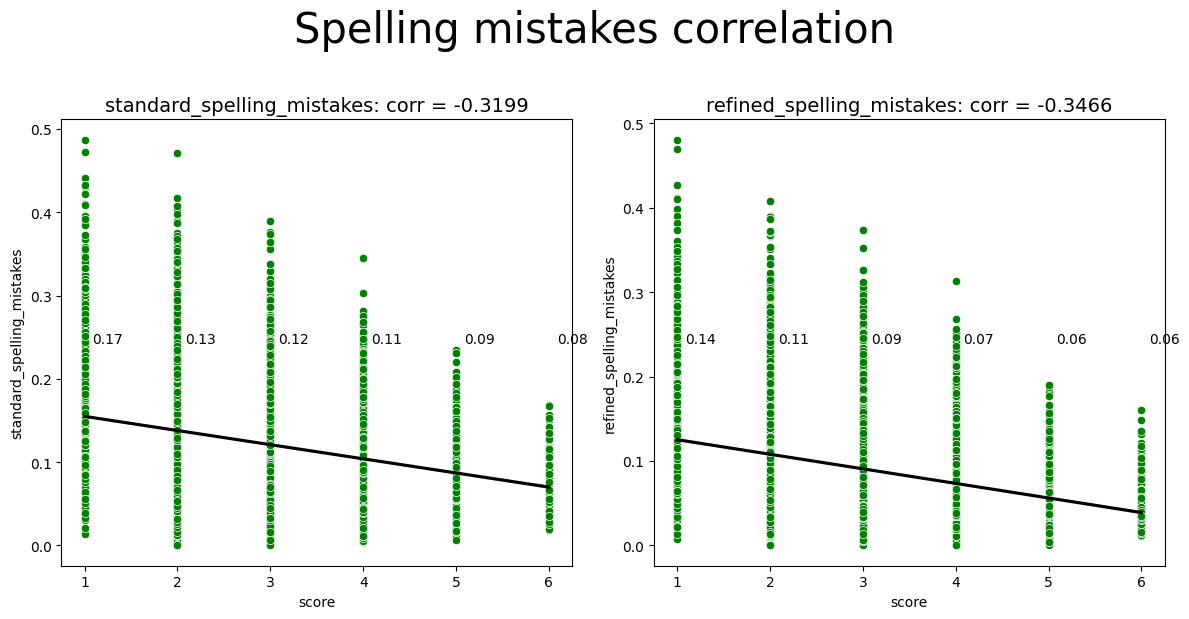

In [6]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# returns whether a set of values largely rise or fall in a linear fashion
def linear(values):
    current = 0 
    positive = []
    negative = []
    for val in values:
        if val > current:
            positive.append(True)
            negative.append(False)
            current = val 
        else:
            positive.append(False)
            negative.append(True)
            current = val 
                
    return (sum(positive)>=5) or (sum(negative)>=4)


# defines y for use in a scatterplot below
y = train['score']


# analyses the relationship between set of features and the y variable
def correlation_analysis(data, var, title=None):

    # creates a subplot object for use below
    row_num = int(np.ceil(len(var) / 3))
    fig, ax = plt.subplots(nrows=row_num, ncols=2, figsize=(12, row_num*6))
    ax = ax.flatten()

    # loops through the variable in question 
    for i, x in enumerate(var):
    
        # calculates an average value of the feature at each score level (1-6)
        avg_x = data.groupby('score')[x].mean().reset_index().iloc[:,1]
    
        # determines the correlation of the feature to y
        corr = round(stats.pearsonr(data[x], y)[0], 4)
    
        # determines whether relationship to score is largely linear or not
        linear_trend = linear(avg_x)
    
        # changes the color based on whether it might be useful to the model or not
        if (abs(corr) >= 0.04) and (linear_trend==True):
            color = 'green'
        else:
            color = 'red'
    
        # creates a scatterplot for each feature
        sns.scatterplot(x=y, y=data[x], ax=ax[i], color=color);
        sns.regplot(x=y, y=data[x], ax=ax[i], scatter=False, color='black');
        ax[i].set_title(x + ': corr = ' + str(round(stats.pearsonr(data[x], y)[0], 4)), size=14);
        
        # adds numerical labels for average value of the feature at each score level (1-6)
        for j, tick in enumerate(avg_x):
            ax[i].text(j+1.25, max(data[x]) / 2, str(round(tick,2)), color='black', ha='center')

    if title == None:
        title = 'Correlation with score'

    plt.suptitle(title, fontsize=30, y=1.025);
    plt.tight_layout();
    plt.show();


# assignts the spelling mistake ratios to the train dataframe
train['standard_spelling_mistakes'] = standard_spelling_mistakes
train['refined_spelling_mistakes'] = refined_spelling_mistakes


# creates an iterable feature list
features = ['standard_spelling_mistakes', 'refined_spelling_mistakes']


# examines the correlations
correlation_analysis(train, features, title='Spelling mistakes correlation')

## Most common misspellings

The most common spelling mistakes are printed below. As we can see, there's still some work to do. The spellchecker library doesn't seem to recognize names, meaning discluding a list of common names could also be useful. However, the potential benefits of this must be balanced against time constraints. On this limited dataset of ~17,000 essays, the refined preprocessing method outlined here already takes 45.21 seconds to complete and would likely grow exponentially with dataset size. 

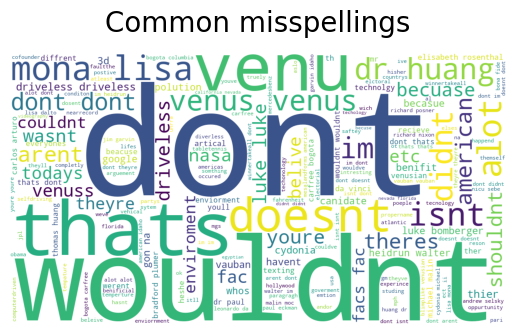

In [7]:
import wordcloud

# retrieves the specific words labelled as misspellings
refined_spelling_mistake_words = [misspelling_count(x)[1] for x in refined_preprocessed_text]


# unlists into a single list
words = []
for list in refined_spelling_mistake_words:
    words.extend(list)


# creates a wordcloud object
wordcloud = wordcloud.WordCloud(background_color="white", width=1100, height=600)
wordcloud.generate(' '.join(words))


# creates a plot of the image
plt.imshow(wordcloud);
plt.axis("off");
plt.title('Common misspellings', size=20, y=1.05);
plt.show();